In [79]:
from OpInf import *
import numpy as np
import scipy
import pywt

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


from pathlib import Path
import json
import stiefel

import importlib
importlib.reload(stiefel)

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "no-latex", "grid"])

np.random.seed(3)

In [80]:
from Representation import *

In [81]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data
T_end_train = 2
dt= 1e-3
Train_T = int(T_end_train/dt)

X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]

In [82]:
def add_noise(data, noise_percentage):
    """
    Add Gaussian noise to the data with a specified noise level.
    """
    signal_std = np.std(data)
    noise_std = noise_percentage * signal_std
    noise = np.random.normal(0, noise_std, data.shape)
    return data + noise

# for each mu, we corrupt the data with gaussian noise to a target SNR
noise_level = 0.10 # 10% noise


X_all_corrupt = []
for i in range(len(mus)):
    X_all_corrupt.append(add_noise(X_all_nominal[i], noise_level))
    
    # targetSNR = 15
    # P_noise = np.var(X_all_nominal[i]) / (10**(targetSNR/10))
    
    # X_all_corrupt.append(X_all_nominal[i] + np.random.normal(0, np.sqrt(P_noise), X_all_nominal[i].shape))
    print("Power of noise:", np.mean(X_all_nominal[i] - X_all_corrupt[i])**2) 
    print(f"SNR for mu={mus[i]}: {10 * np.log10(np.var(X_all_nominal[i]) / np.var(X_all_nominal[i] - X_all_corrupt[i]))} \n")

X_all_corrupt = np.array(X_all_corrupt)

Power of noise: 1.954434053390621e-09
SNR for mu=1.1: 20.024016280716907 

Power of noise: 1.2887782551837797e-08
SNR for mu=1.05: 19.99053714062845 

Power of noise: 1.0051665362985311e-08
SNR for mu=1: 20.012762550834545 

Power of noise: 1.284615687430101e-09
SNR for mu=0.95: 20.031813059986916 

Power of noise: 6.645027561180797e-10
SNR for mu=0.9: 20.011099925658225 



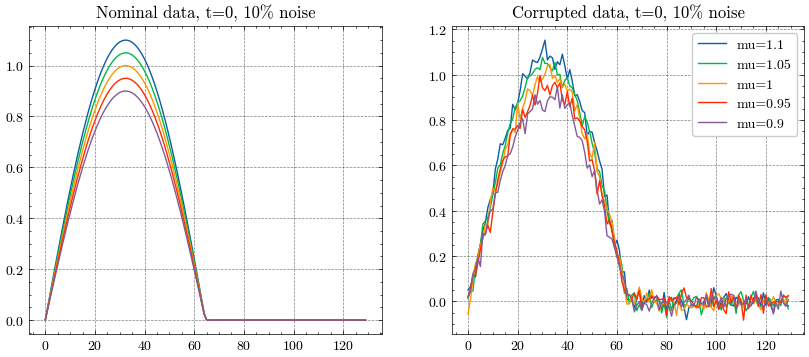

In [83]:
# visualize the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  
for i, mu in enumerate(mus):
    axs[0].plot(X_all_nominal[i, 0, :], label=f"mu={mu}")
    axs[1].plot(X_all_corrupt[i, 0, :], label=f"mu={mu}")
    axs[0].set_title("Nominal data, t=0, 10% noise")
    axs[1].set_title("Corrupted data, t=0, 10% noise")
    plt.legend()
plt.show()

/home/jy384/miniconda3/envs/fenicsx/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 130, using nperseg = 130
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


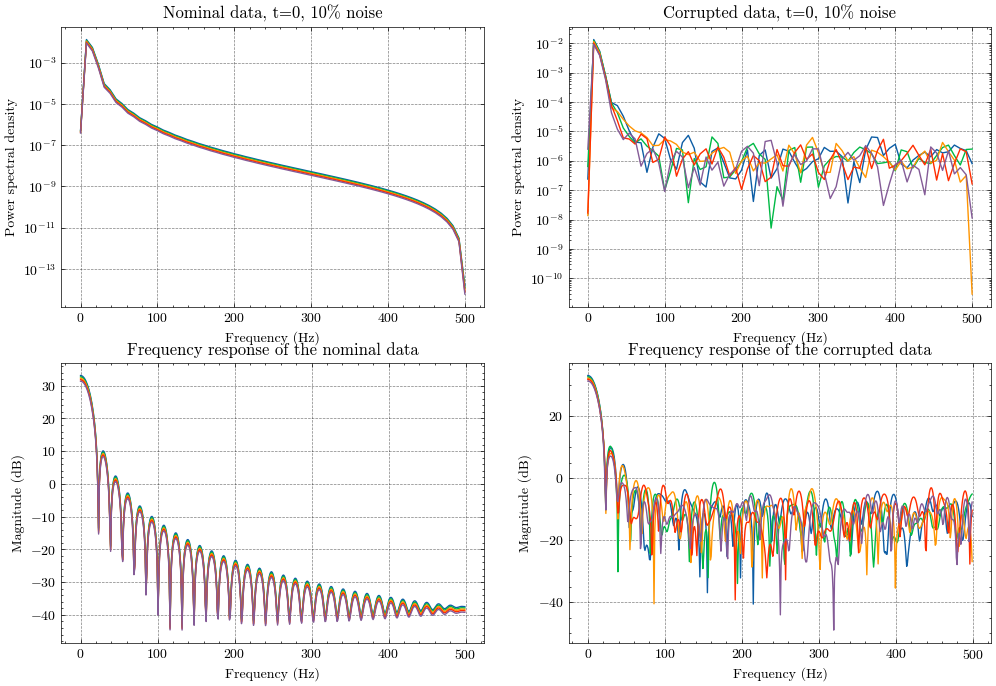

In [84]:
# frequency analysis
from scipy.signal import welch
from scipy import fftpack

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, mu in enumerate(mus):
    f, Pxx = welch(X_all_nominal[i, 0, :], fs=1/dt, nperseg=1024)
    axs[0, 0].semilogy(f, Pxx, label=f"mu={mu}")
    f, Pxx = welch(X_all_corrupt[i, 0, :], fs=1/dt, nperseg=1024)
    
    w, H = scipy.signal.freqz(X_all_nominal[i, 0, :])
    w_corrupt, H_corrupt = scipy.signal.freqz(X_all_corrupt[i, 0, :])
    
    axs[0, 1].semilogy(f, Pxx, label=f"mu={mu}")
    axs[1, 0].plot(w/np.pi*(1/dt)/2.,20*np.log10(abs(H)), label=f"mu={mu}")
    axs[1, 1].plot(w_corrupt/np.pi*(1/dt)/2.,20*np.log10(abs(H_corrupt)), label=f"mu={mu}")
    
    
    axs[0, 0].set_title("Nominal data, t=0, 10% noise")
    axs[0, 1].set_title("Corrupted data, t=0, 10% noise")
    axs[1, 0].set_title("Frequency response of the nominal data")
    axs[1, 1].set_title("Frequency response of the corrupted data")
    
    # set x label
    axs[0, 0].set_xlabel("Frequency (Hz)")
    axs[0, 1].set_xlabel("Frequency (Hz)")
    axs[1, 0].set_xlabel("Frequency (Hz)")
    axs[1, 1].set_xlabel("Frequency (Hz)")
    
    # set y label
    axs[0, 0].set_ylabel("Power spectral density")
    axs[0, 1].set_ylabel("Power spectral density")
    axs[1, 0].set_ylabel("Magnitude (dB)")
    axs[1, 1].set_ylabel("Magnitude (dB)")
    


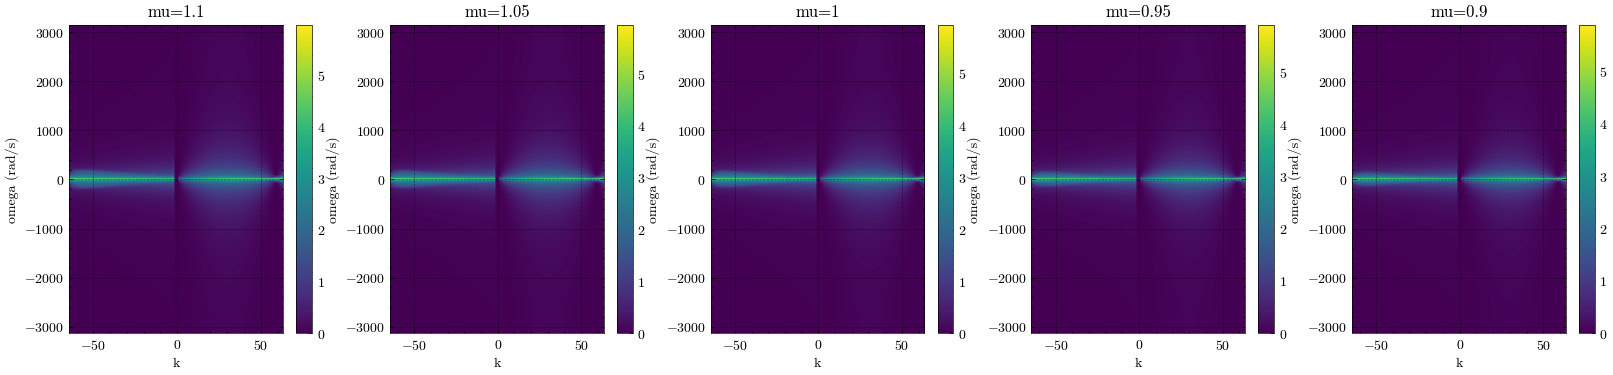

In [85]:
# plot frequency spectrum

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, mu in enumerate(mus):
    komega_spec = np.abs(fftpack.fftshift(fftpack.fft(X_all_nominal[i], axis=0))) ** 2
    # komega_spec[komega_spec.shape[0] // 2, komega_spec.shape[1] // 2] = 0  # Remove DC component
    
    om_ax = 2 * np.pi * fftpack.fftshift(fftpack.fftfreq(X_all_nominal[i].shape[0], d=dt))
    k_ax = np.fft.fftshift(np.fft.fftfreq(X_all_nominal[i].shape[1], d=1/129))
    extent = [k_ax.min(), k_ax.max(), om_ax.min(), om_ax.max()]
    log_komega_spec = np.log10(komega_spec + 1)
    
    axs[i].imshow(log_komega_spec, aspect="auto", extent=extent)
    cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=log_komega_spec.min(), vmax=log_komega_spec.max()), cmap="viridis"), ax=axs[i])
    
    axs[i].set_title(f"mu={mu}")
    axs[i].set_xlabel("k")
    axs[i].set_ylabel("omega (rad/s)")
plt.show()  

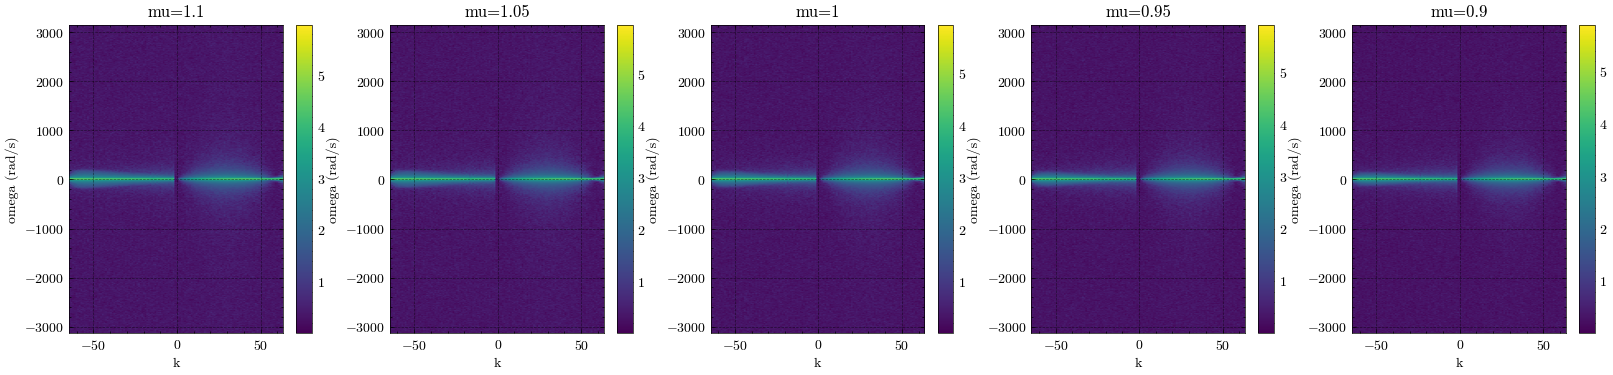

In [86]:
# plot frequency spectrum of corrupted data
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, mu in enumerate(mus):
    komega_spec = np.abs(fftpack.fftshift(fftpack.fft(X_all_corrupt[i], axis=0))) ** 2
    
    om_ax = 2 * np.pi * fftpack.fftshift(fftpack.fftfreq(X_all_corrupt[i].shape[0], d=dt))
    k_ax = np.fft.fftshift(np.fft.fftfreq(X_all_corrupt[i].shape[1], d=1/129))
    extent = [k_ax.min(), k_ax.max(), om_ax.min(), om_ax.max()]
    log_komega_spec = np.log10(komega_spec + 1)
    axs[i].imshow(log_komega_spec, aspect="auto", extent=extent)
    cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=log_komega_spec.min(), vmax=log_komega_spec.max()), cmap="viridis"), ax=axs[i])
    
    axs[i].set_title(f"mu={mu}")
    axs[i].set_xlabel("k")
    axs[i].set_ylabel("omega (rad/s)")
plt.show()

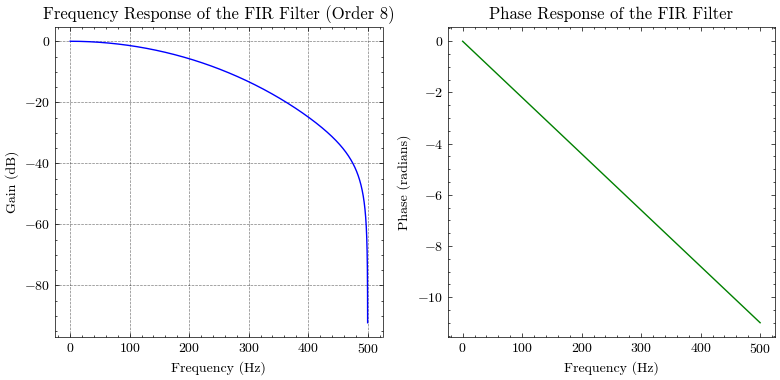

In [87]:
# design filter
import numpy as np
from scipy.signal import firwin, lfilter, freqz, butter, filtfilt, kaiserord
import matplotlib.pyplot as plt

def design_fir_filter(numtaps, cutoff, fs):
    """
    Design a low-pass FIR filter using the window method.
    
    Parameters:
    - numtaps: The number of taps in the filter.
    - cutoff: The cutoff frequency in Hz.
    - fs: The sampling rate in Hz.
    
    Returns:
    - fir_coeff: The coefficients of the FIR filter.
    """
    # Normalize the cutoff frequency with respect to Nyquist rate
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    
    # Use the Hamming window
    fir_coeff = firwin(numtaps, normalized_cutoff, window='hamming')
    return fir_coeff



def design_fir_filter_kaiser(numtaps, fpass, fstop, fs, delta):
    """
    Design a low-pass FIR filter using the Kaiser window method.
    
    Parameters:
    - numtaps: The number of taps in the filter.
    - fpass: The passband frequency in Hz.
    - fstop: The stopband frequency in Hz.
    - fs: The sampling rate in Hz.
    - delta: The maximum ripple in the passband.
    
    Returns:
    - fir_coeff: The coefficients of the FIR filter.
    """
    # Normalize the passband and stopband frequencies with respect to Nyquist rate
    nyquist = 0.5 * fs
    normalized_fpass = fpass / nyquist
    normalized_fstop = fstop / nyquist
    
    # Use the Kaiser window
    width = normalized_fstop - normalized_fpass
    beta, atten = kaiserord(delta, width)
    fir_coeff = firwin(numtaps, normalized_fpass, window=('kaiser', beta))
    return fir_coeff
    
    

def plot_frequency_response(fir_coeff, fs):
    """
    Plot the frequency and phase response of the FIR filter.
    
    Parameters:
    - fir_coeff: The coefficients of the FIR filter.
    - fs: The sampling rate in Hz.
    """
    # freq, response = freqz(fir_coeff, worN=8000)
    # # Magnitude response
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(0.5 * fs * freq / np.pi, np.abs(response), 'b')
    # plt.title('Magnitude Response of the FIR Filter')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Gain')
    # plt.grid()
    freq, response = freqz(fir_coeff, worN=8000)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(0.5 * fs * freq / np.pi, 20 * np.log10(np.abs(response)), 'b')
    plt.title(f'Frequency Response of the FIR Filter (Order {len(fir_coeff)})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.grid(True)
    # plt.show()


    # Phase response
    plt.subplot(1, 2, 2)
    phase_response = np.unwrap(np.angle(response))
    plt.plot(0.5 * fs * freq / np.pi, phase_response, 'g')
    plt.title('Phase Response of the FIR Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid()
    plt.tight_layout()
    plt.show()

    
    
def apply_fir_filter(data, fir_coeff):
    """
    Apply the FIR filter to the data.
    
    Parameters:
    - data: The input signal data as a numpy array.
    - fir_coeff: The coefficients of the FIR filter.
    
    Returns:
    - filtered_data: The filtered signal data.
    """
    filtered_data = lfilter(fir_coeff, 1.0, data)
    return filtered_data


def apply_fir_filter_zero_phase(data, fir_coeff):
    """
    Apply the FIR filter to the data with zero phase distortion.
    
    Parameters:
    - data: The input signal data as a numpy array.
    - fir_coeff: The coefficients of the FIR filter.
    
    Returns:
    - filtered_data: The filtered signal data.
    """
    filtered_data = filtfilt(fir_coeff, 1.0, data)
    return filtered_data


def apply_fir_filter_with_padding(data, fpass, fstop, fs, delta, pad_length):
    """
    Apply a Kaiser window FIR filter with reflect padding.

    Parameters:
    - data: Input data signal as a numpy array.
    - fpass: Passband frequency in Hz.
    - fstop: Stopband frequency in Hz.
    - fs: Sampling frequency in Hz.
    - delta: Desired stopband attenuation in dB.
    - pad_length: Number of samples to pad at each end.
    
    Returns:
    - filtered_data: Filtered signal with padding removed.
    """
    # Calculate parameters for the Kaiser window
    nyquist = 0.5 * fs
    width = (fstop - fpass) / nyquist
    numtaps, beta = kaiserord(delta, width)
    fir_coeff = firwin(numtaps, fpass / nyquist, window=('kaiser', beta))

    # Reflect padding
    padded_data = np.pad(data, pad_length, 'reflect')

    # Zero-phase filtering with padding
    filtered_padded_data = filtfilt(fir_coeff, [1], padded_data)

    # Remove padding

    filtered_data = filtered_padded_data[pad_length:-pad_length, pad_length:-pad_length]
    return filtered_data



def wavelet_denoising(data, wavelet_name='db4', mode='soft', level=2):
    """
    Apply wavelet denoising to the data for preserving sharp transitions.
    
    Parameters:
    - data: The input signal data as a numpy array.
    - wavelet_name: Name of the wavelet used.
    - mode: Thresholding mode used in denoising ('soft' or 'hard').
    - level: The level of wavelet decomposition.
    
    Returns:
    - denoised_data: The denoised signal data.
    """
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(data, wavelet_name, level=level)
    # Estimate the median of the absolute deviation of the smallest scale wavelet coefficients
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    # Apply thresholding
    coeff[1:] = [pywt.threshold(i, value=threshold, mode=mode) for i in coeff[1:]]
    # Reconstruct the signal
    denoised_data = pywt.waverec(coeff, wavelet_name)
    return denoised_data


def butter_lowpass(cutoff, fs, order=2):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_zero_phase(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# # Design the FIR filter
# fir_coeff = design_fir_filter(numtaps=15, cutoff=80, fs=1/dt)
fir_coeff = design_fir_filter_kaiser(numtaps=8, fpass=80, fstop=150, fs=1/dt, delta=20)

# Plot the frequency response of the FIR filter
plot_frequency_response(fir_coeff, fs=1/dt)


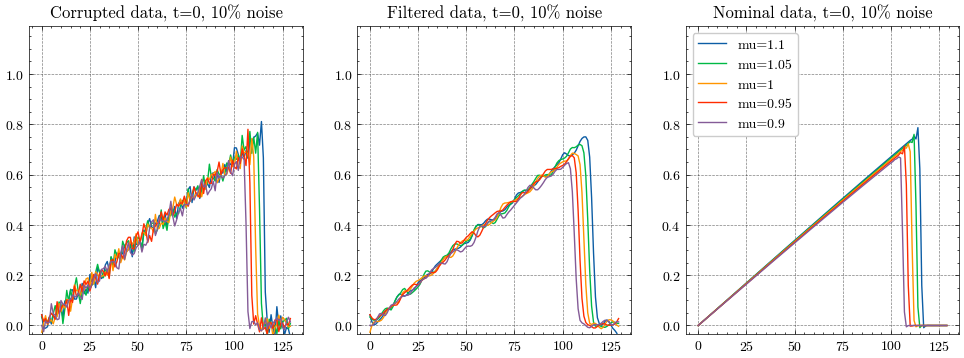

In [88]:
# apply the filter to the data
X_all_corrupt_filtered = []
for i in range(len(mus)):
    X_all_corrupt_filtered.append(apply_fir_filter_zero_phase(X_all_corrupt[i], fir_coeff))
    # X_all_corrupt_filtered.append(apply_fir_filter_with_padding(X_all_corrupt[i], fpass=80, fstop=100, fs=1/dt, delta=20, pad_length=5))
    # X_all_corrupt_filtered.append(butter_lowpass_zero_phase(X_all_corrupt[i], cutoff=120, fs=1/dt, order=1))
    # X_all_corrupt_filtered.append(wavelet_denoising(X_all_corrupt[i], wavelet_name='db4', mode='soft', level=3))
    
X_all_corrupt_filtered = np.array(X_all_corrupt_filtered)

# visualize the data
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, mu in enumerate(mus):
    axs[0].plot(X_all_corrupt[i, 1000, :], label=f"mu={mu}")
    axs[1].plot(X_all_corrupt_filtered[i, 1000, :], label=f"mu={mu}")
    axs[2].plot(X_all_nominal[i, 1000, :], label=f"mu={mu}")
    
    axs[0].set_title("Corrupted data, t=0, 10% noise")
    axs[1].set_title("Filtered data, t=0, 10% noise")
    axs[2].set_title("Nominal data, t=0, 10% noise")
    
    # set same y limit
    axs[0].set_ylim([X_all_nominal.min() * 1.01, X_all_nominal.max() * 1.01])
    axs[1].set_ylim([X_all_nominal.min() * 1.01, X_all_nominal.max() * 1.01])
    axs[2].set_ylim([X_all_nominal.min() * 1.01, X_all_nominal.max() * 1.01])
    
    
    plt.legend()
plt.show()


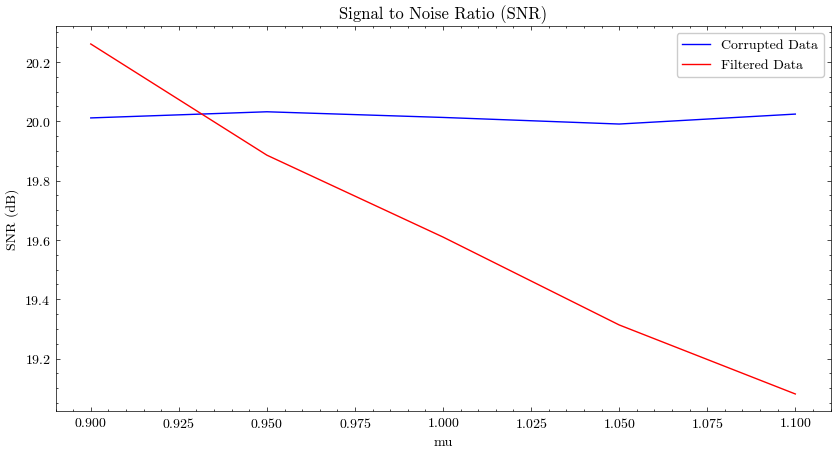

In [89]:
# calculate signal to noise ratio
def calculate_snr(signal, noisy_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB).
    """
    signal_power = np.var(signal)
    noise_power = np.mean( (signal - noisy_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calculate the SNR of the corrupted data
snr_corrupt = []
for i in range(len(mus)):
    snr_corrupt.append(calculate_snr(X_all_nominal[i], X_all_corrupt[i]))

# Calculate the SNR of the filtered data
snr_filtered = []
for i in range(len(mus)):
    snr_filtered.append(calculate_snr(X_all_nominal[i], X_all_corrupt_filtered[i]))

# Plot the SNR
plt.figure(figsize=(10, 5))
plt.plot(mus, snr_corrupt, 'b', label='Corrupted Data')
plt.plot(mus, snr_filtered, 'r', label='Filtered Data')
plt.xlabel('mu')
plt.ylabel('SNR (dB)')
plt.title('Signal to Noise Ratio (SNR)')
plt.legend()
plt.grid()
plt.show()

[2, 4, 6, 8, 10]


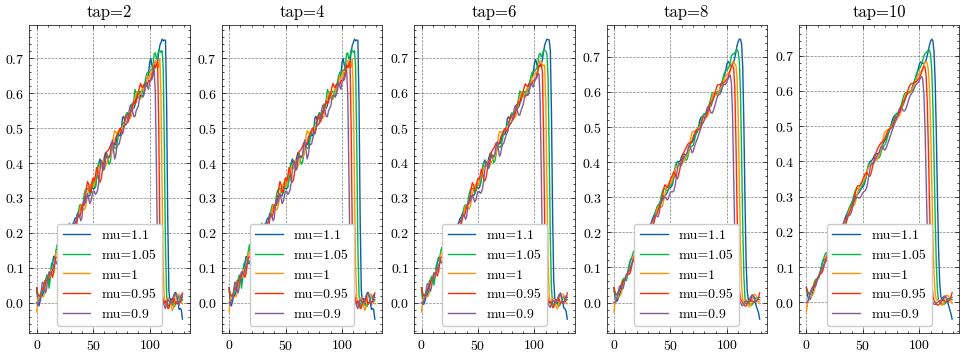

In [90]:
# different level of filtering by varying the tap number, corresponding to low fidelity data, medium fidelity data, high fidelity data
# odd number of taps as a spacing of 1
# numtaps = [3+i for i in range(9)]
numtaps = [i for i in range(2, 12, 2)]
# numtaps = [8, 16, 24, 32]
# numtaps = [2**i + 1 for i in range(1, 4)]
# numtaps = [i for i in range(2, 10, 2)]
print(numtaps)
# numlevels = [1, 2, 3, 4]

X_list = []
X_all_corrupt_filtered = np.empty((len(numtaps), len(mus), X_all_corrupt.shape[1], X_all_corrupt.shape[2]))

# plot the filtered data with different number of taps
fig, axs = plt.subplots(1, len(numtaps), figsize=(12, 4))
for i, mu in enumerate(mus):
    for j, taps in enumerate(numtaps):
        fir_coeff = design_fir_filter_kaiser(numtaps=taps, fpass=80, fstop=150, fs=1/dt, delta=20)
        X_all_corrupt_filtered[j, i] = apply_fir_filter_zero_phase(X_all_corrupt[i], fir_coeff)
        # X_all_corrupt_filtered[j, i] = wavelet_denoising(X_all_corrupt[i], wavelet_name='db4', mode='soft', level=numlevels[j])
        axs[j].plot(X_all_corrupt_filtered[j, i][1000, :], label=f"mu={mu}")
        axs[j].set_title(f"tap={taps}")
        # axs[j].set_title(f"level={numlevels[j]}")
        axs[j].legend()

Text(0.5, 1.0, 'Corrupted data for mu=1')

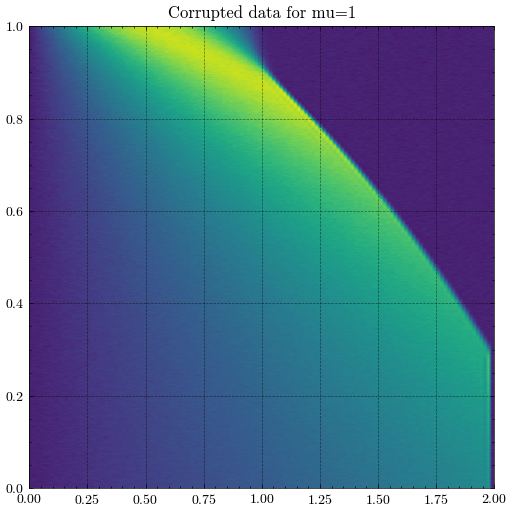

In [91]:
# plot the corrupted data for mu = 1
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
XX, YY = np.meshgrid(np.linspace(0.0, T_end_train, int(T_end_train/dt)+1), np.linspace(0.0, 1.0, 129))
axs.imshow(X_all_corrupt[2], aspect="auto", extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)])
axs.set_title("Corrupted data for mu=1")

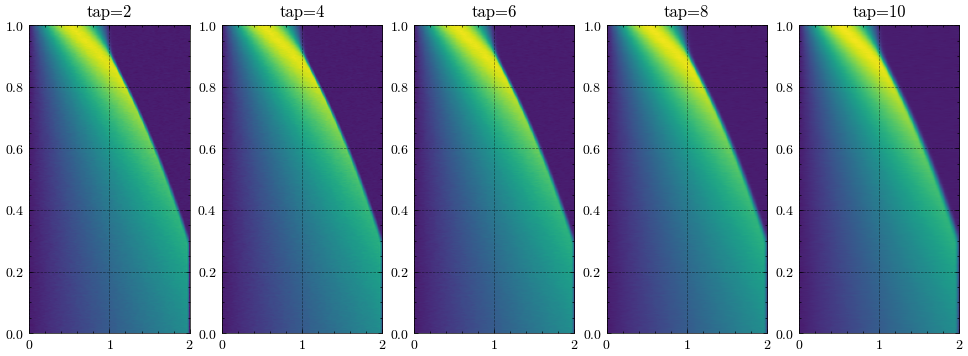

In [92]:
# plot the image of full data for mu=1
fig, axs = plt.subplots(1, len(numtaps), figsize=(12, 4))
for i in range(len(numtaps)):
    axs[i].imshow(X_all_corrupt_filtered[i, 2], aspect="auto", extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)])
    axs[i].set_title(f"tap={numtaps[i]}")
plt.show()

In [93]:
p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [94]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

N = int(config['N'])
coord = np.linspace(0, 1, N)

X =  (130, 10005)
X_ref =  (130, 1)
S =  [195.88637917 118.42783047  75.18851723  56.44224881  42.85373477]
idx =  10
rel_err_SVD[idx] =  0.041460648084471474
X =  (130, 10005)
X_ref =  (130, 1)
S =  [195.51325861 117.97461956  74.6375016   55.94627142  42.27928475]
idx =  8
rel_err_SVD[idx] =  0.03640345904027453
X =  (130, 10005)
X_ref =  (130, 1)
S =  [195.5131778  117.97451858  74.63737485  55.94614885  42.27913918]
idx =  8
rel_err_SVD[idx] =  0.0364012446597628
X =  (130, 10005)
X_ref =  (130, 1)
S =  [194.98595565 117.31200691  73.79203869  55.10639935  41.27139761]
idx =  7
rel_err_SVD[idx] =  0.031964061329647464
X =  (130, 10005)
X_ref =  (130, 1)
S =  [194.61298541 116.8402056   73.17602656  54.47599433  40.50958601]
idx =  6
rel_err_SVD[idx] =  0.03574078427393146
X =  (130, 10005)
X_ref =  (130, 1)
S =  [195.33071419 117.74606278  74.34903747  55.66457793  41.9433645 ]
idx =  8
rel_err_SVD[idx] =  0.03171488413664547


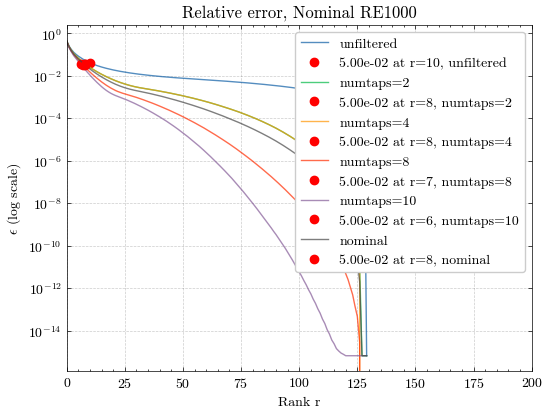

In [95]:
# X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T

X_list = [np.concatenate([X for X in X_all_corrupt_filtered[i]], axis=0).T for i in range(len(numtaps))]

# Enforce ICs and BCs
IC = np.array([initial_condition(c) for c in coord])
for i in range(len(X_list)):
    X_list[i][:, 0] = IC

    # Enforce BCs
    X_list[i][0, :] = 0
    X_list[i][-1, :] = 0

# Use tap=8 as the nominal data by first determining the index and moving it to the last
# Use levle=2 as the nominal data by first determining the index and moving it to the last
idx_nominal = numtaps.index(6)
X_list.append(X_list.pop(idx_nominal))

# rearrange numtaps
numtaps.append(numtaps.pop(idx_nominal))

# insert unfilted data as the front
X_list.insert(0, np.concatenate([X for X in X_all_corrupt], axis=0).T)

rob_lst = []
rel_err_SVD_lst = []
idx_lst = []

# names = [f"tap={numtaps[i]}" for i in range(len(numtaps))]
names = [f"numtaps={numtaps[i]}" for i in range(len(numtaps))]
names.insert(0, "unfiltered")
names[-1] = "nominal"


fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 5e-2

# mus = [0.01] # only one mu for now

for i in range(len(X_list)):
    
    X = X_list[i]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal RE1000")
    ax.legend()

In [96]:
# Model parameters
# r = np.max(idx_lst)
r = idx_lst[-1]
q_trunc = 2
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(len(X_list)):
    # Procustes problem for each mu
    X = X_list[i]
    
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    X_ref = np.mean(X, axis=1)[:, None]
    # X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r + q_trunc]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    energy = np.linalg.norm(Vr @ q + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(X - X_ref, 'fro')**2
    
    print(f"Snapshot energy: {energy:e}")

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.439656e-01

Reconstruction error: 23.6709%
num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.610289e-01

Reconstruction error: 19.7403%
num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.610312e-01

Reconstruction error: 19.7397%
num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.729774e-01

Reconstruction error: 16.4376%
num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.785427e-01

Reconstruction error: 14.6472%
num_snapshots:  10005
X =  (130, 10005)
Snapshot energy: 9.658159e-01

Reconstruction error: 18.4881%


In [97]:
# # Aligning the signs of Vr_lst with Vr_lst[-1]
# nominal_signs = np.sign(Vr_lst[-1])
# non_zero_signs_ind = nominal_signs != 0
# for i in range(len(Vr_lst) - 1):
#     max_inds = np.argmax(Vr_lst[-1], axis=0) # max indexes for each column corresponding to the largest value in each column
#     for j in range(Vr_lst[i].shape[1]):
#         if np.sign(Vr_lst[i][max_inds[j], j]) != np.sign(Vr_lst[-1][max_inds[j], j]):
#             Vr_lst[i][:, j] = -Vr_lst[i][:, j]

# # For Vbar_lst, ensuring sign agreement with Vbar_lst[-1] using np.copysign
# for i in range(len(Vbar_lst)):
#     Vbar_lst[i] = np.copysign(Vbar_lst[i], Vbar_lst[-1])

# # Verifying the changes
# print(Vr_lst)  # Adjusted matrices
# print(Vbar_lst)  # Adjusted matrices


In [98]:
for i in range(len(Vr_lst)):
    np.allclose(Vr_lst[0].T @ Vr_lst[0], np.identity(Vr_lst[0].shape[1]))

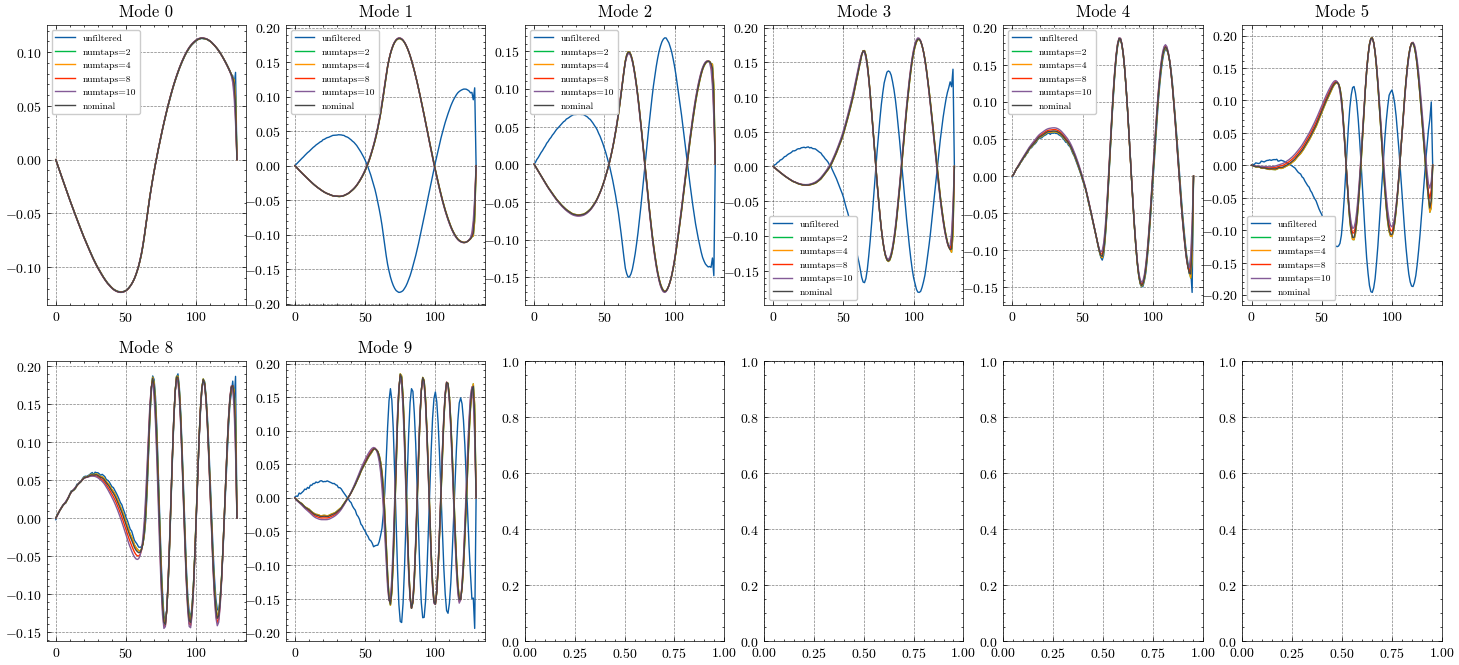

In [99]:
# plot first 5 modes of Vr and Vbar
n_modes_viz = 6
fig, axs = plt.subplots(2, n_modes_viz, figsize=(18, 8))
for i in range(n_modes_viz):
    for j in range(len(Vr_lst)):
        axs[0, i].plot(Vr_lst[j][:, i], label=names[j])
        axs[0, i].legend(fontsize='x-small')
    axs[0, i].set_title(f"Mode {i}")

for i in range(2):
    for j in range(len(Vbar_lst)):
        axs[1, i].plot(Vbar_lst[j][:, i])
    axs[1, i].set_title(f"Mode {r + i}")

In [100]:
X = X_list[-1]
# IC = np.array([initial_condition(c) for c in coord])
# X[:, 0] = IC

# # Enforce BCs
# X[0, :] = 0
# X[-1, :] = 0

X_ref = np.mean(X, axis=1)[:, None]
# X_ref = np.zeros((X.shape[0]))[:, None]
X_centered = X - X_ref

Vr = Vr_lst[-1]
Vbar = Vbar_lst[-1]
q = Vr.T @ X_centered

Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='4c')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="4c")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [101]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


In [102]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

print("Shape of Shat_py: ", Shat_py.shape)
print("Shape of dShatdt_py: ", dShatdt_py.shape)

Shape of Shat_py:  (8, 9985)
Shape of dShatdt_py:  (9985, 8)


In [103]:
X_list[-1].shape

(130, 10005)

In [104]:
config['robparams'] = {
    "r": int(r)
}

N = int(config['N'])
dt = config['dt']
T_end = config['T_end']
mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
Mp = config['Mp']
K = int(config['K'])
DS = config['DS']
params = config['params']  # This will be a dictionary in Python
robparams = config['robparams']  # This will be a dictionary in Python

coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
# q0 = Vr.T @ (X_list[-1][:, 0][:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1] // len(mus)

# regs = [1e1, 3e3, 1e9]
# regs = [0.001, 20, 1e5]
Shat_true = Shat_lst[2]
# regs_product = [1e-3, 1e1, 3, 1e1, 1e4, 10, 1e1, 1e7, 7]

# regs_product = [1e-3, 1e-3, 1, 1e-1, 1e-1, 1, 27.825594022071257, 27.825594022071257, 1] # for r=5
# regs_product = [10, 10, 1, 43.939705607607905, 43.939705607607905, 1, 27.825594022071257, 27.825594022071257, 1] # for r=5
# regs_product = [800, 800, 1, 15000, 15000, 1, 10000000000, 100000000000, 1]
regs_product = [1e-2, 1e-2, 1, 500, 500, 1, 1000000, 1000000, 1] # for r=12
# regs_product = [10, 10, 1, 4.47213595e+01, 4.47213595e+01, 1, 1.00000000e+07, 1.00000000e+07, 1] # for r=32
# [1.00000000e+01, 4.47213595e+01, 1.00000000e+07]
# [10.0, 129.1549665014884, 1000000.0]

# [10.0, 43.939705607607905, 27.825594022071257]
# regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
# regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
# regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
print("Train size: ", train_size)
print("Shat_true shape: ", Shat_true.shape)
regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)


coord =  (130,)
Train size:  1997
Shat_true shape:  (8, 1997)
Constructing least-squares solver, r=8
TRAINING 1 ROMS
(1/1) Testing ROM with (0.01, 499.99999999999994, 1000000.0)
Generating ghat ...
drp:  100
Obtained data matrix...
Regularization parameters:  0.01 499.99999999999994 1000000.0
Solving...
Solved!
Integrating...
Bound check passed


In [105]:
regs

[0.01, 499.99999999999994, 1000000.0]

In [106]:
errors

0.04247274730469534

In [107]:
# regs = [0.0005399173326341194, 23.61197176062329, 202651972.5062846]

params['lambda1'] = regs[0]
params['lambda2'] = regs[1]
if len(regs) > 2:
    params['lambda3'] = regs[2]

# params['lambda1'] = (5e-2)**2
# params['lambda2'] = (5e-2)**2
# if len(regs) > 2:
#     params['lambda3'] = regs[2]
operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)

Generating ghat ...
drp:  100
Obtained data matrix...
Regularization parameters:  0.01 499.99999999999994 1000000.0
Solving...
Solved!


In [108]:
from stiefel import *
import importlib
importlib.reload(stiefel)
N_stiefel_samples = 1000

V_combined_lst = [np.concatenate([Vr, Vbar], axis=1) for Vr, Vbar in zip(Vr_lst, Vbar_lst)]

# Generate the samples and split them into two arrays
stiefel_samples_combined = stiefel.gen_stiefel_samples(N_stiefel_samples, V_combined_lst, tau=0.00001, metric_alpha=0.0000000000)
stiefel_samples_Vr = np.array([sample[:, :r] for sample in stiefel_samples_combined])
stiefel_samples_Vbar = np.array([sample[:, r:r+q_trunc] for sample in stiefel_samples_combined])

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 10 12:23:20 AM: Your problem has 5 variables, 3 constraints, and 0 parameters.
(CVXPY) May 10 12:23:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 10 12:23:20 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 10 12:23:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 10 12:23:20 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------

In [109]:
frechet_mean = calc_frechet_mean_mat(stiefel_samples_combined, V_combined_lst[-1], eps=1e-2, tau=1e-3)

Vr_frechet_mean = frechet_mean[0][:, :r]
Vbar_frechet_mean = frechet_mean[0][:, r:]

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic

In [110]:
# beta = [0.44149277269871695, 0.15169986271138602, 1e-15, 0.4068073645898959]

Vbar numtaps=10
Vbar numtaps=8
Vbar numtaps=4
Vbar numtaps=2
Vbar unfiltered


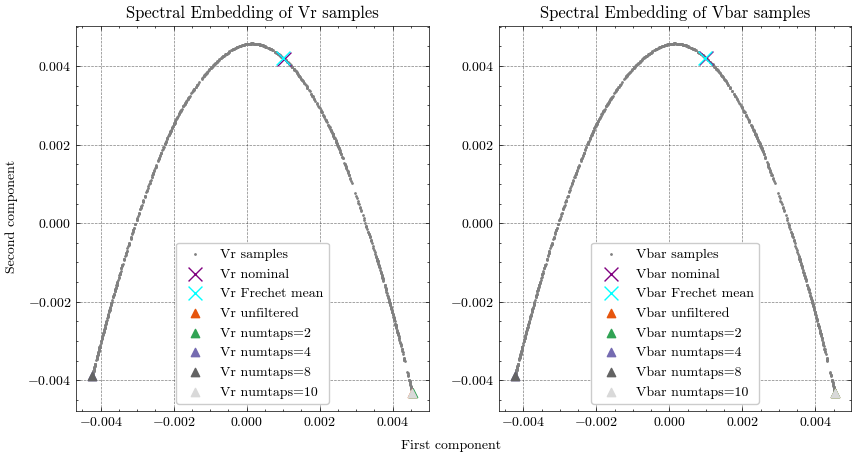

In [111]:
# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
flat_Vr_frechet_mean = Vr_frechet_mean.flatten()[:, None]
flat_Vbar_frechet_mean = Vbar_frechet_mean.flatten()[:, None]
rob_Vr_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vr] + [flat_Vr_arr] + [flat_Vr_frechet_mean], axis=1)
rob_Vbar_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vbar] + [flat_Vbar_arr] + [flat_Vbar_frechet_mean], axis=1)

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

# colors = 
colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst)))


# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)

# Plot the embeddings
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(embedding_Vr[:-2, 0], embedding_Vr[:-2, 1], color='gray', s=1, label='Vr samples')
plt.scatter(embedding_Vr[-2, 0], embedding_Vr[-2, 1], color='purple', label='Vr nominal', marker='x', s=100)
plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='cyan', label='Vr Frechet mean', marker='x', s=100)


for i in range(1, len(Vr_lst)):
    plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], color=colors[i], label=f"Vr {names[i-1]}", marker='^')
    # plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], label=f"Vr {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])

plt.legend()
plt.title('Spectral Embedding of Vr samples')
# plt.xlabel('First component')
# plt.ylabel('Second component')


plt.subplot(1, 2, 2)
plt.scatter(embedding_Vbar[:-2, 0], embedding_Vbar[:-2, 1], color='gray', s=1, label='Vbar samples')
plt.scatter(embedding_Vbar[-2, 0], embedding_Vbar[-2, 1], color='purple', label='Vbar nominal', marker='x', s=100)
plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='cyan', label='Vbar Frechet mean', marker='x', s=100)

for i in range(1,len(Vbar_lst)):
    plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], color=colors[i], label=f"Vbar {names[i-1]}", marker='^')
    print(f"Vbar {names[-i-1]}")
    # plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], label=f"Vbar {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])
    

plt.legend()
plt.title('Spectral Embedding of Vbar samples')

# plt.xlabel('First component')
# plt.ylabel('Second component')

# Add common x and y labels
fig.text(0.5, 0.04, 'First component', ha='center', va='center')
fig.text(0.06, 0.5, 'Second component', ha='center', va='center', rotation='vertical')
plt.show()

In [112]:
modelform = config['params']['modelform']

def rhs(t, state, operators, multi_indices, modelform, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        mask = ckron_indices(state.shape[0])
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out


In [113]:
X_all_nominal_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")

In [114]:
T_end_index = int(T_end/dt)

In [115]:
# nominal s_rec_full

Vr = Vr_lst[-1]
Vbar = Vbar_lst[-1]


coord = np.linspace(0, 1, N)
# print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

T_end_full = 8
time_domain_full = np.arange(0, T_end_full, dt)

train_size = Shat_py.shape[1]

multi_indices = generate_multi_indices_efficient(len(q0), p=p)


modelform = config['params']['modelform']
out_full = scipy.integrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain_full[0], time_domain_full[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain_full,  # evaluated at these points
            args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
            
        )

s_hat_full = out_full.y
poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
Xi = Xi_lst[-1] # the nominal Xi
# print("Poly shape: ", poly_full.shape)

s_rec_full_nominal = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full


abs_error_full_nominal = np.abs(X_all_nominal_full[2].T - s_rec_full_nominal)
relative_error_testing_window_nominal = np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:] - s_rec_full_nominal[:, T_end_index:], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:], 'fro')
relative_error_training_window_nominal = np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index] - s_rec_full_nominal[:, :T_end_index], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index], 'fro')


In [116]:
import tqdm

N_samples = 1000
abs_error_full_lst = []
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
s_rec_full_lst = []

for i in tqdm.tqdm(range(N_samples)):
    # # randomly choose 1 from stiefel_samples_Vr and 1 from stiefel_samples_Vbar
    # idx_Vr = np.random.randint(0, N_stiefel_samples)
    # idx_Vbar = np.random.randint(0, N_stiefel_samples)
    
    # print(i)
    
    Vr_sample = stiefel_samples_Vr[i]
    Vbar_sample = stiefel_samples_Vbar[i]
    

    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr_sample.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
                
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    Xi = Xi_lst[-1] # the nominal Xi
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_nominal_full[2].T - s_rec_full)
    relative_error_testing_window = np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_nominal_full[2].T[:, :T_end_index], 'fro')
    
    abs_error_full_lst.append(abs_error_full)
    relative_error_testing_window_lst.append(relative_error_testing_window)
    relative_error_training_window_lst.append(relative_error_training_window)
    s_rec_full_lst.append(s_rec_full)
    
    

100%|██████████| 1000/1000 [00:20<00:00, 48.16it/s]


In [117]:
# mean relative error across the testing window
mean_relative_error_testing = np.mean(relative_error_testing_window_lst)
std_relative_error_testing = np.std(relative_error_testing_window_lst)
# coeff_var = std_relative_error_testing / mean_relative_error_testing
print(f"Mean relative error: {mean_relative_error_testing:.4%}")
print(f"Std relative error: {std_relative_error_testing:.4%}")
# print(f"Coefficient of variation: {coeff_var:.4%}")

Mean relative error: 93.8874%
Std relative error: 0.1961%


In [118]:
# coefficient of variation of s_rec_full
# coeff_var_s_rec_full = np.std(s_rec_full_lst, axis=0) / (np.mean(s_rec_full_lst, axis=0))
std_s_rec_full = np.std(s_rec_full_lst, axis=0)
std_s_rec_full_testing = std_s_rec_full[T_end_index:]
std_s_rec_full_training = std_s_rec_full[:T_end_index]

In [119]:
#  mean reconstruction
mean_s_rec_full = np.mean(s_rec_full_lst, axis=0)
mean_s_rec_full_testing = mean_s_rec_full[T_end_index:]
mean_s_rec_full_training = mean_s_rec_full[:T_end_index]

In [120]:
# calculate 95% confidence interval
confidence_interval = 1.96 * std_s_rec_full

X =  (8000, 130)
Y =  (8000, 130)
s_ref_all[i] =  (0, 8000)


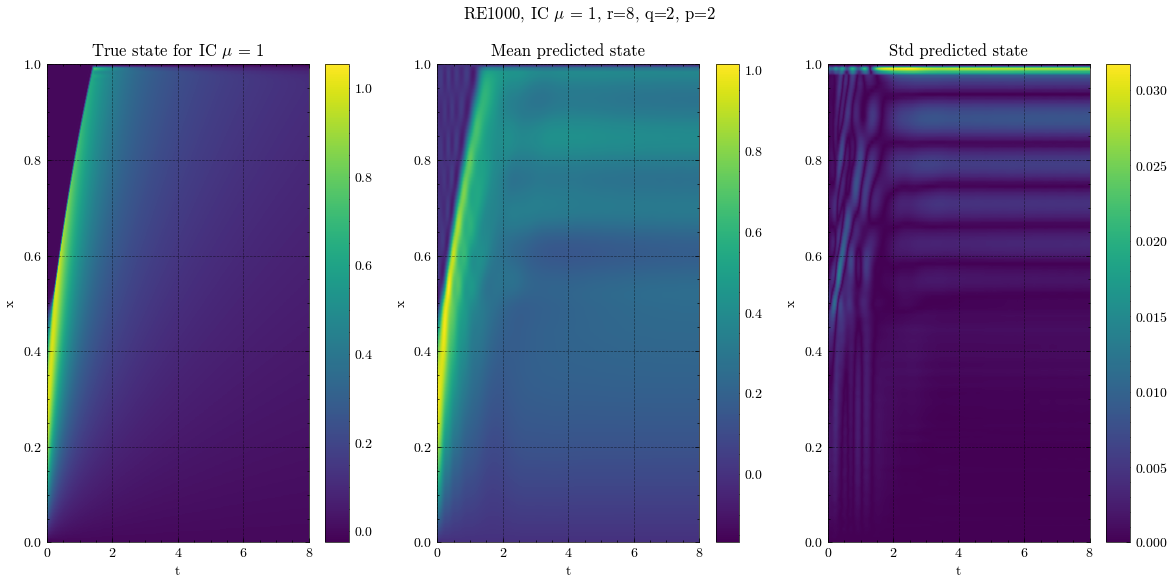

In [121]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", mean_s_rec_full_testing.shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    
    c0 = axs[0].imshow(X_all_nominal_full[2].T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c0, ax=axs[0], orientation='vertical')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'True state for IC $\mu$ = {mus[2]}')
    
    c1 = axs[1].imshow(mean_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=axs[1], orientation='vertical')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Mean predicted state')
    
    c2 = axs[2].imshow(std_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=axs[2], orientation='vertical')
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('x')
    axs[2].set_title(f'Std predicted state')
    
    
    # fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.suptitle(f"RE1000, IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}")
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'RE1000, nominal model solution for IC $\\mu$ = 1, r=8, q=2, p=2')

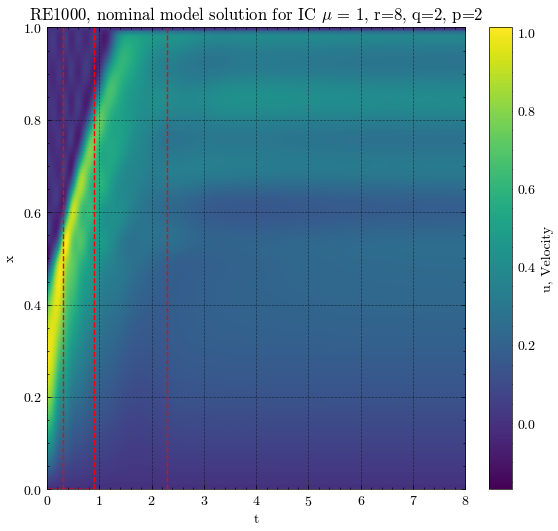

In [122]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


# plot 95% confidence interval of the solution
fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
upper_bound = mean_s_rec_full + confidence_interval
lower_bound = mean_s_rec_full - confidence_interval

XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(s_rec_full_nominal.T.shape[0])), np.linspace(0.0, 1.0, s_rec_full_nominal.T.shape[1]))

# surf = ax.plot_surface(XX, YY, s_rec_full_nominal, cmap='viridis', alpha=0.7)

contour = ax.imshow(s_rec_full_nominal, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=np.min(s_rec_full_nominal.T), vmax=np.max(s_rec_full_nominal.T)), cmap='viridis'), ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('u, Velocity')


# draw vertical plane at t=0.125, 0.375, 1,75
times = [0.3, 0.9, 2.3]
for t in times:
    ax.plot([t, t], [0, 1], [0, 0], color='red', linestyle='--')


ax.set_xlabel('t')
ax.set_ylabel('x')
# ax.set_zlabel('u')
ax.set_title(f'RE1000, nominal model solution for IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}')


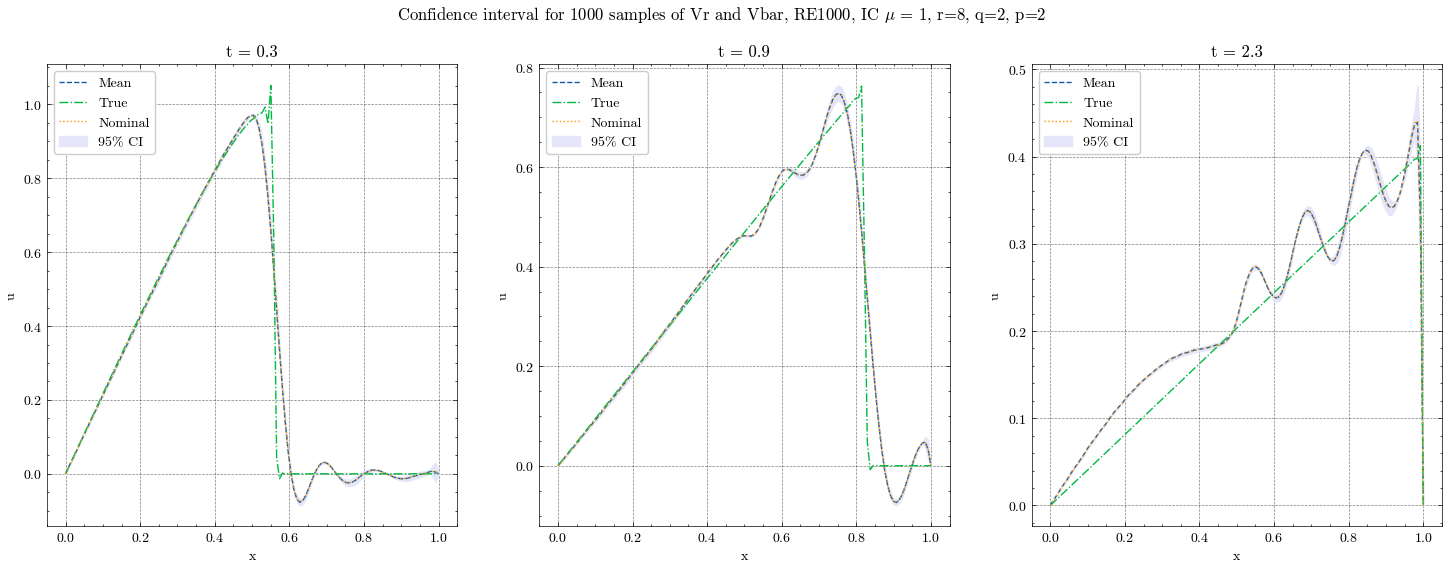

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Example setup (you'll need to define mean_s_rec_full, lower_bound, and upper_bound appropriately)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, t in enumerate(times):
    ax = axs[i]
    t_index = int(t / dt)  # Ensure dt is defined and properly calculated

    # Main plot
    x_values = np.linspace(0, 1, mean_s_rec_full.shape[0])
    mean_line = mean_s_rec_full[:, t_index]
    nominal_line = s_rec_full_nominal[:, t_index]
    true_line = X_all_nominal_full[2].T[:, t_index]
    lower_line = lower_bound[:, t_index]
    upper_line = upper_bound[:, t_index]
    
    ax.plot(x_values, mean_line, label='Mean', linestyle="--")
    ax.plot(x_values, true_line, label='True', linestyle="-.")
    ax.plot(x_values, nominal_line, label='Nominal', linestyle=":")
    ax.fill_between(x_values, lower_line, upper_line, alpha=1, label='95% CI', color='lavender')
    ax.set_title(f"t = {t}")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(loc="upper left")

    # # Create an inset axis
    # axins = inset_axes(ax, width="25%", height="25%", loc='center right')

    # # Plot the same data on the inset
    # axins.plot(x_values, mean_line, linestyle="--")
    # axins.plot(x_values, true_line, linestyle="-.")
    # axins.plot(x_values, nominal_line, linestyle=":")
    
    # if np.allclose(lower_line, upper_line):
    #     print("Lower and upper bounds are the same")
    #     axins.plot(x_values, lower_line, color='lavender')
    # else:
    #     print("Lower and upper bounds are different")
    #     axins.fill_between(x_values, lower_line, upper_line, color='lavender', alpha=1)

    # # Zoom-in range for the x-axis
    # focus_x_min, focus_x_max = 0.8, 0.81
    # axins.set_xlim(focus_x_min, focus_x_max)
    # axins.set_ylim(np.min(lower_line), np.max(upper_line))

    # # Dynamically determine the y-range based on the focus area
    # mask = (x_values >= focus_x_min) & (x_values <= focus_x_max)
    # focus_y_min = min(np.min(lower_line[mask]), np.min(mean_line[mask]))
    # focus_y_max = max(np.max(upper_line[mask]), np.max(mean_line[mask]))
    # y_margin = (focus_y_max - focus_y_min) * 0.1  # Adjust margin
    # axins.set_ylim(focus_y_min - y_margin, focus_y_max + y_margin)

    # # Optionally remove tick labels to declutter
    # axins.xaxis.set_tick_params(labelbottom=True)
    # axins.yaxis.set_tick_params(labelleft=True)

# plt.tight_layout()
plt.suptitle(f"Confidence interval for 1000 samples of Vr and Vbar, RE1000, IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}")
plt.show()
